In [52]:
library(tidyverse)
library(readxl)
library(magrittr)
library(lubridate)


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



In [179]:
#import cpi data
cpi_raw <- read_csv("cpi_raw_data.csv")
glimpse(cpi_raw)
#rename the index number column
colnames(cpi_raw)[6] = "Index_number"#

Parsed with column specification:
cols(
  Level = col_character(),
  `Series ref: CPIQ` = col_character(),
  Description = col_character(),
  Quarter = col_character(),
  Weight = col_double(),
  `Index number` = col_double()
)


Observations: 8,198
Variables: 6
$ Level              <chr> "All groups", "Group", "Group", "Group", "Group"...
$ `Series ref: CPIQ` <chr> "SE9A", "SE901", "SE902", "SE903", "SE904", "SE9...
$ Description        <chr> "All groups CPI", "Food", "Alcoholic beverages a...
$ Quarter            <chr> "2006Q2", "2006Q2", "2006Q2", "2006Q2", "2006Q2"...
$ Weight             <dbl> 100.00, 17.39, 7.20, 4.75, 20.02, 5.49, 5.23, 17...
$ `Index number`     <dbl> 815.6607, 759.8784, 628.5355, 1002.0040, 694.444...


In [180]:
# The CPI data has an entire breakdown of the CPI for all quarters
#We only want the rows that are tagged with "all groups" so need to filter those rows
#and select the columns with quarter and index values

cpi_raw %<>%
        select(Level,Quarter,Index_number) %>%
        filter(Level == "All groups") %>%
        select(-Level)
tail(cpi_raw)

Quarter,Index_number
2017Q2,1000.000
2017Q3,1004.894
2017Q4,1006.000
2018Q1,1011.000
2018Q2,1015.000
2018Q3,1024.000


In [163]:
#import fuel price data
fuel_price_raw <- read_csv("fuel_price_raw.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  Week_ending_Friday = col_character(),
  Week_number = col_character(),
  Status = col_character()
)
See spec(...) for full column specifications.


In [177]:
tail(fuel_price_raw)

Week_ending_Friday,Petrol_price_cpl,Week,Quarter
31/08/2018,218.3914,2018-08-31,2018Q3
7/09/2018,220.1057,2018-09-07,2018Q3
14/09/2018,223.5343,2018-09-14,2018Q3
21/09/2018,224.3914,2018-09-21,2018Q3
28/09/2018,226.3914,2018-09-28,2018Q3
5/10/2018,231.7131,2018-10-05,2018Q4


In [165]:
#import fuel price data
fuel_price_raw <- read_csv("fuel_price_raw.csv")

#Select only the date and petrol price
fuel_price_raw %<>%
    select(Week_ending_Friday, Petrol_discounted_retail_price_NZc.p.l )

#The inflation data is reported by quarter so turn the date stamps
# into quarterly labels that match the quarter labels in the index data
colnames(fuel_price_raw)[2] = "Petrol_price_cpl"#
fuel_price_raw %<>%
    mutate(Week = dmy(Week_ending_Friday)) %>%
    mutate(Quarter = paste0(year(Week),"Q",quarter(Week)))

#Only want the price and the quarter for the price
#since we are joining with the inflation data
fuel_price <- fuel_price_raw %>%
        select(Quarter,Petrol_price_cpl)

Parsed with column specification:
cols(
  .default = col_double(),
  Week_ending_Friday = col_character(),
  Week_number = col_character(),
  Status = col_character()
)
See spec(...) for full column specifications.


In [173]:
#Join the price and cpi data (by Quarter)
#only joins the tables where we have both the cpi and price
#data for that quarter
fuel_inflation <- inner_join(fuel_price,cpi_raw, by = "Quarter")

fuel_inflation %>% head()

Quarter,Petrol_price_cpl,Index_number
2006Q2,156.2,815.6607
2006Q2,159.3,815.6607
2006Q2,164.5,815.6607
2006Q2,168.8,815.6607
2006Q2,170.9,815.6607
2006Q2,170.9,815.6607


In [184]:
#There are approximately 12 weeks in every quarter
#so take the average of these prices for each quarter to smooth the data
#We couldn't get group_by to work for some reason so 
#used aggregate
avg_fuel_inflation <- aggregate(fuel_inflation[, 2:3], list(fuel_inflation$Quarter), mean)
colnames(avg_fuel_inflation)[1] = "Quarter"
head(avg_fuel_inflation)

Quarter,Petrol_price_cpl,Index_number
2006Q2,167.7846,815.6607
2006Q3,166.0615,821.3703
2006Q4,140.9231,819.7390
2007Q1,142.3077,823.8173
2007Q2,153.8231,831.9739
2007Q3,156.6000,836.0522


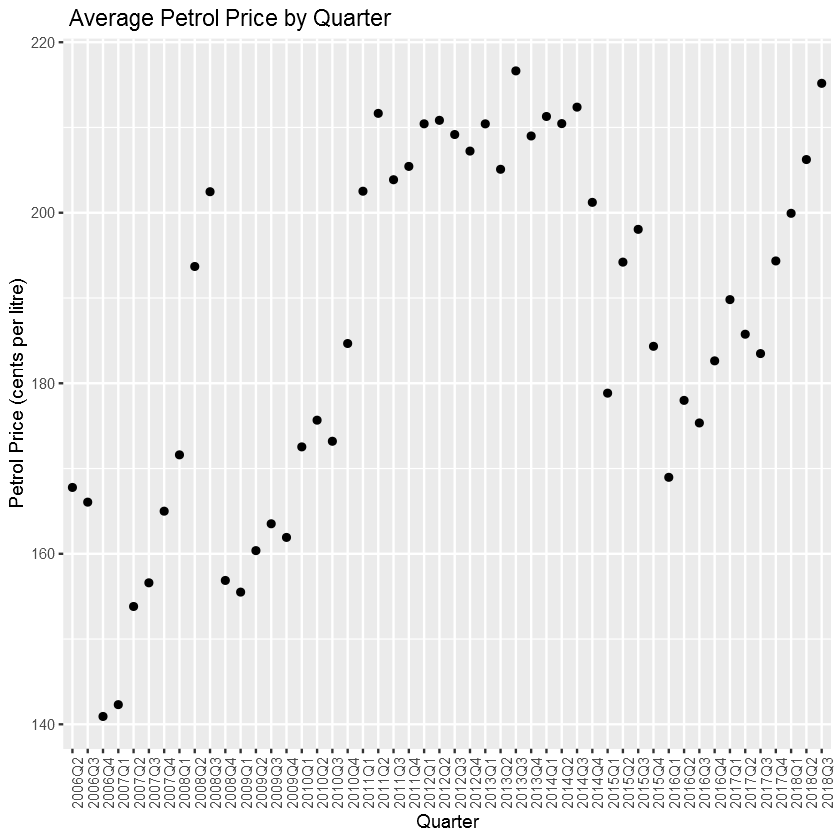

In [185]:
#Plot fuel price over time
#Note since the quarterly figures are averaged from weekly data and 
#we don't have the inflation figures for quarter 4 yet so this graph doesn't
#include the new fuel taxes from the 1st October 2018
avg_fuel_inflation %>%
    ggplot( aes(x = Quarter, y = Petrol_price_cpl) )+geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    ggtitle(" Average Petrol Price by Quarter")+
    
xlab("Quarter")+ylab ("Petrol Price (cents per litre)")

Quarter,Petrol_price_cpl,Index_number,Inflation_adjusted_price
2006Q2,167.7846,815.6607,167.7846
2006Q3,166.0615,821.3703,164.9072
2006Q4,140.9231,819.7390,140.2220
2007Q1,142.3077,823.8173,140.8987
2007Q2,153.8231,831.9739,150.8069
2007Q3,156.6000,836.0522,152.7805


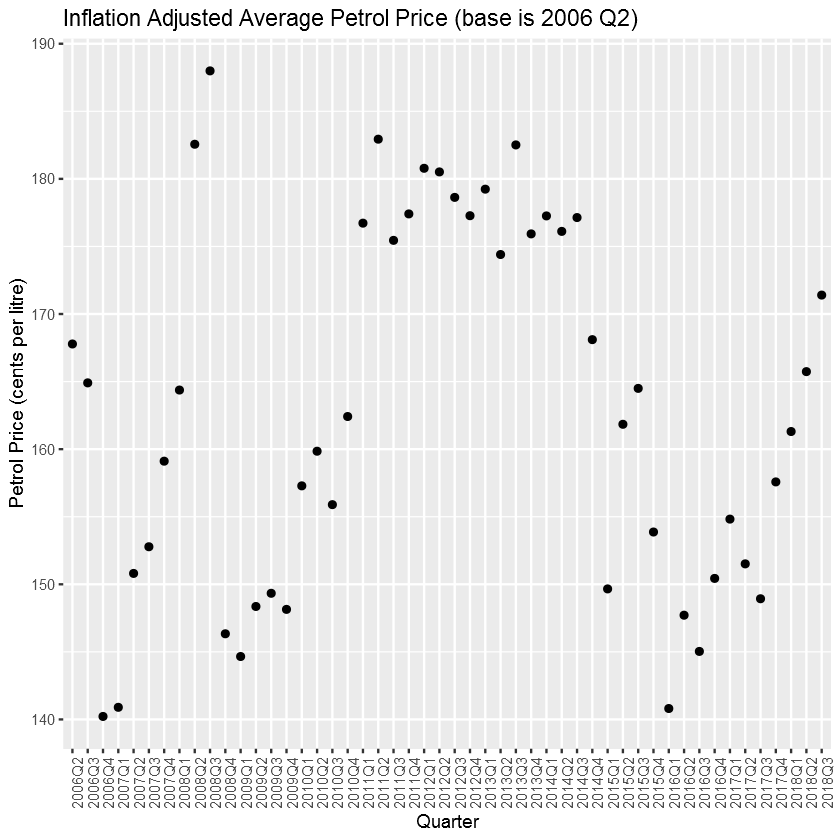

In [190]:
#Want to adjust the fuel price for inflation
#so take the base level from 2006 Q2 - the first quarter in the table

base_index = avg_fuel_inflation[[3]][1]

#add a column to the table for inflation adjusted price
avg_fuel_inflation %<>% mutate(Inflation_adjusted_price = Petrol_price_cpl * base_index/ Index_number)
avg_fuel_inflation %>% head()

#Plot the inflation adjusted price data
avg_fuel_inflation%>%
      ggplot( aes(x = Quarter, y = Inflation_adjusted_price) )+geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
        ggtitle("Inflation Adjusted Average Petrol Price (base is 2006 Q2)")+
        xlab("Quarter")+ylab ("Petrol Price (cents per litre)")

[1] 164.846